# Example 2: Fire weather in Portugal

How much CO2 can be emitted until 2050 to keep the probability of 50 days of extreme fire weather in Portugal below 15% (in 2050)?

The following analysis is based on MESMER-X emulations for the emission scenarios developed for the PROVIDE project (https://zenodo.org/records/6833278).

The MESMER-X emulations are agregated by GMT levels and percentiles are stored in `fwixd_PRT_percentiles_for_GMT_levels.nc` (added to this repository).

To reproduce this analysis please use the download the scenario emissions and temperature data for PROVIDE project: https://zenodo.org/records/6833278

If you also want to reproduce `fwixd_PRT_percentiles_for_GMT_levels.nc` please have a look at [Ex_fire_weather_supplement.ipynb](Ex2_fire_weather_supplement.ipynb)

In [1]:
import os,sys,glob,traceback, pickle
import pandas as pd
import xarray as xr
import numpy as np
import scipy
from scipy import stats
from scipy.special import erf
import matplotlib.pyplot as plt
from multiprocessing import Pool

In [ ]:
# percentiles from MESMER-X
# these are the percentiles of fwixd for GMT values in 0.1K steps
# see Ex2_fire_weather_supplement.ipynb for details
percentiles = xr.open_dataarray('../fwixd_PRT_percentiles_for_GMT_levels.nc')

In [ ]:
year = 2050
# number of days
threshold = 50
# limit probability for the future
p_limit = 0.15

In [ ]:
# gmt for the 2237 runs of the 1500 tier2 scenarios in 2050
gmt = xr.open_dataset(f'gmt_in_{year}.nc')['gmt']

In [ ]:
def prob_greater_at_gmt(g, thresh):
    '''
    returns the probability of staying below the threshold at given GMT g
    '''
    y = percentiles.sel(gmt=g, method='nearest')
    return 1 - percentiles.p.values[np.abs(y - thresh).argmin()] / 100

def prob_greater_in_scenario(scen, thresh):
    '''
    returns the probability of crossing thresh in given scenario
    '''
    # get all gmt values in 2050 from the 2237 runs
    # bin GMT in 0.1 K steps
    # and count occurences in bins
    counter = Counter(gmt.loc[scen].round(1).values)
    p = np.array([])
    # for each bin add the probability of crossing threshold at GMT level "count"-times
    for g,count in counter.items():
        p = np.append(p, [prob_greater_at_gmt(g, thresh)]*count)
    return p

In [ ]:
# get probability of crossing crossing the threshold for each scenario
p_greater = xr.DataArray(dims=['scenario'], coords=dict(scenario=scenarios))
for scenario in scenarios:
    p_greater.loc[scenario] = prob_greater_in_scenario(scenario, threshold).mean()

In [ ]:
# identify boundary scenarios that are close to the limit probability
boundary_scenarios = p_greater.scenario[np.abs(p_greater - p_limit) < 0.001]

In [ ]:
gmt_median = xr.open_dataset('gmt_median.nc')['gmt']

In [ ]:
# load fair emissions
emissions = pd.read_table('../Tier2_scenarios_emissions.csv', sep=',')
co2 = emissions.loc[(emissions.Variable == 'Emissions|CO2')]
co2 = xr.DataArray(co2.iloc[:,5:].values, dims=['scen','year'], coords=dict(scen=co2.Scenario, year=np.array(co2.columns[5:], 'int')))
ch4 = emissions.loc[(emissions.Variable == 'Emissions|CH4')]
ch4 = xr.DataArray(ch4.iloc[:,5:].values, dims=['scen','year'], coords=dict(scen=ch4.Scenario, year=np.array(ch4.columns[5:], 'int')))
cum_co2 = (co2.loc[:,2020:year].rolling(year=2).sum() * 0.5 * 10).sum('year') / 1000

In [ ]:
# get cumulative CO2 emissions until 2050 in the orange scenario
CO2_budget = cum_co2.loc[boundary_scenarios].values.mean()
CO2_budget

437.53523800016046

'2030fact0.32_nz2050_ov0_meth0.25'

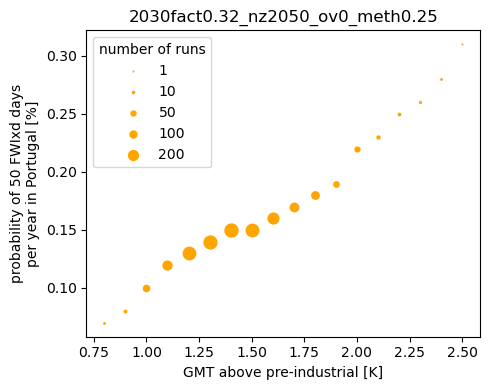

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(5,4), sharey=True)
scen = boundary_scenarios.values[5]
for g in np.unique(gmt.loc[scen].round(1).values):
    ax.scatter(g, prob_greater_at_gmt(g, threshold), color='orange', marker='.', s=np.sum(gmt.loc[scen].round(1).values==g))
for s in [1,10,50,100,200]:
    ax.scatter([],[], color='orange', marker='.', s=s, label=s)
ax.set_xlabel('GMT above pre-industrial [K]')
ax.set_ylabel('probability of 50 FWIxd days\nper year in Portugal [%]')
ax.set_title(scen)
ax.legend(title='number of runs')
plt.tight_layout()
plt.savefig('example_2.pdf')
plt.savefig('example_2.png', dpi=300)
scen